# ARIM情報活用講座：　
# 論文：Prediction of organic compound aqueous solubility using machine learning  
### Part-2 (Morganフィンガープリント)

Tayyebi, A., Alshami, A.S., Rabiei, Z. et al. Prediction of organic compound aqueous solubility using machine learning: a comparison study of descriptor-based and fingerprints-based models. J Cheminform 15, 99 (2023).   
https://doi.org/10.1186/s13321-023-00752-6

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!pip install shap

!git clone https://github.com/ARIM-Training/Training_python_12.git
%cd Training_python_12

## 1.データの読み込み
### 汎用ライブラリのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#importing rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw

# 警告を無視
from warnings import filterwarnings
filterwarnings('ignore')

### データセットファイルの読み込み
Part-1と同じくnew222new.csvを読み出してデータフレーム型のsol変数とします。

In [2]:
sol = pd.read_csv('data/new222new.csv')
sol

,SMILES,measured log(solubility:mol/L)
0,OCC1OC(CO)(OC2OC(CO)C(O)C(O)C2O)C(O)C1O,0.79
1,O[C@H]1[C@H](O[C@H](CO)[C@@H](O)[C@@H]1O)O[C@]...,0.79
2,OC[C@@H]1O[C@](CO)(O[C@@H]2O[C@@H](CO)[C@H](O)...,0.79
3,CN1C[C@@H]2C[C@@H](C1)C3=CC=CC(=O)N3C2,0.65
4,CN1CC2CC(C1)C1=CC=CC(=O)N1C2,0.65
...,...,...
8433,O=[N+]([O-])C,0.26
8434,OC,1.57
8435,S=C(N)N,0.32
8436,O=C(NO)N,1.12


In [3]:
XY = sol.set_index('SMILES').T.to_dict('list')

In [4]:
y = sol.iloc[:,1]
y

0       0.79
1       0.79
2       0.79
3       0.65
4       0.65
        ... 
8433    0.26
8434    1.57
8435    0.32
8436    1.12
8437    0.96
Name: measured log(solubility:mol/L), Length: 8438, dtype: float64

## 2. Morganフィンガープリント

### SMILESからのハッシュ化
8438の化合物のSMILES構造からMolオブジェクトを生成します。具体的には、['SMILES']列に`MolFromSmiles`メソッドを適用し、新たに生成されたMolオブジェクトを`AllChem.GetMorganFingerprintAsBitVect()`メソッドにforループで逐次的に処理を進めます。ここでは半径2、ビット数2,048で行われます。

In [5]:
X = []

for smile, Hlist in XY.items():
    try:
        X.append(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2,nBits = 2048))

    except:
        pass

X = [list(a) for a in X]

In [6]:
print(len(X))

8438


### 特徴量の刈り込み
特徴量の刈り込みは、ハッシュ値がゼロのビット（ゼロビット）を排除します。その方法はLassoを使って重み係数がゼロの項目を排除する性質を利用して行います。LASSOのハイパーパラメータであるalpha値は0.001としています。

In [7]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

In [8]:
x = X

# Fit a LASSO regression model on the fingerprints and target variable
reg = Lasso(alpha=0.001)
reg.fit(x, y)

nonzero_indices = [i for i, coef in enumerate(reg.coef_) if coef != 0]

for i in nonzero_indices:
    print("Bit", i, ":", reg.coef_[i])

# Select the columns with nonzero coefficients from the x array
x_nonzero = [[row[i] for i in nonzero_indices] for row in x]

Bit 0 : 0.15992486260998626
Bit 1 : -0.314310741986557
Bit 2 : -0.47280287374293856
Bit 9 : -0.3470528778216867
Bit 13 : 0.027709619200126927
Bit 16 : -0.3010756541847232
Bit 25 : -0.04018562205882949
Bit 28 : -0.0970214909725354
Bit 31 : -0.33521220002929825
Bit 34 : 0.03380562901904102
Bit 39 : -0.21536888667525103
Bit 41 : 0.31535895618497073
Bit 44 : -0.5337646822379348
Bit 56 : 0.1876388588317961
Bit 58 : -0.039880872272325715
Bit 59 : -0.7401574496081016
Bit 65 : 0.13629423260492382
Bit 72 : -0.13130941645919603
Bit 78 : 0.12729189673034658
Bit 80 : -0.04074445215769715
Bit 81 : -0.0962485893246244
Bit 89 : 0.12937162441053748
Bit 90 : 0.09242576298392345
Bit 92 : 0.2429288347896073
Bit 97 : -0.4907157202804343
Bit 106 : -0.1763715095796103
Bit 110 : -0.15785162045035972
Bit 112 : -0.07564167501141077
Bit 113 : -1.1628027822776854
Bit 114 : -0.6751883296566326
Bit 115 : 0.2396560351746468
Bit 116 : -0.7283114328213194
Bit 118 : 0.008900234171002762
Bit 121 : -0.38843102383814904


In [9]:
print(len(nonzero_indices))

631


In [10]:
X_prune = x_nonzero
print(len(X_prune))

8438


## ２.機械学習モデリング
機械学習モデリングは線形重線形回帰 (MLR) とランダムフォレスト（RF）の二つのアルゴリズムで検討をしています。
説明変数は、上記で作成したMorganフィンガープリント（X）です。対して、目的変数は水溶解度で、最初に読み込ませたsolの2列目をYとして定義します。

## Case1: 631ビット

### データセットの分割（Data set splitting）
分割は`test_size=0.2`として訓練データ：0.8、テストデータ：0.2としています。

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_prune, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=991
                                                   )

### 2-1.線形重回帰 (MLR) 

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [13]:
linearmodel=LinearRegression()
linearmodel.fit(X_train, Y_train)

LinearRegression()

### R2スコア

In [14]:
#predicts the X_train
Y_pred_train = linearmodel.predict(X_train)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (MSE): 0.88
Coefficient of determination (R^2): 0.78


In [15]:
#predicts the X_test
Y_pred_test = linearmodel.predict(X_test)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))
print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.96
Coefficient of determination (R^2): 0.74


### MAE

In [16]:
mae = mean_absolute_error(Y_train, Y_pred_train)
print('Training MAE : {:.3f}'.format(mae))

Training MAE : 0.657


In [17]:
mae = mean_absolute_error(Y_test, Y_pred_test)
print('Test MAE : {:.3f}'.format(mae))

Test MAE : 0.730


### RMSE

In [18]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.3f}'.format(rmse))

Training RMSE : 0.877


In [19]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.3f}'.format(rmse))

Test RMSE : 0.962


### Exp-Predict Plot

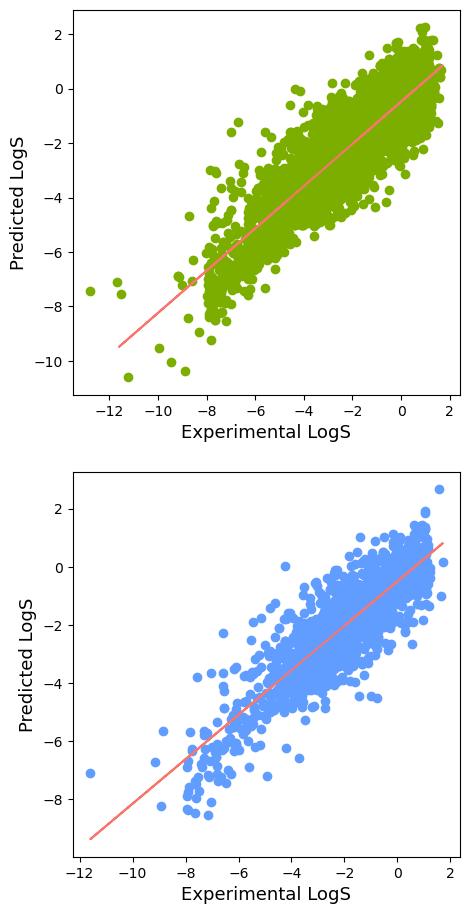

In [20]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)

# 出力
#plt.savefig('output/plot_vertical_logS_ECFP_MLR.png')
#plt.savefig('output/paper logS descriptor_ECFP_MLR.pdf',dpi=300)

plt.show()

### 2-2.ランダムフォレスト回帰（RFR）

In [21]:
from sklearn.ensemble import RandomForestRegressor

In [22]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

### R2スコア

In [23]:
#predicts the X_train
Y_pred_train = model.predict(X_train)

print('Mean squared error (MSE): %.3f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.3f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (MSE): 0.352
Coefficient of determination (R^2): 0.964


In [24]:
Y_pred_test = model.predict(X_test)

print('Mean squared error (MSE): %.3f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))

print('Coefficient of determination (R^2): %.3f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.810
Coefficient of determination (R^2): 0.814


### MAE

In [25]:
mae = mean_absolute_error(Y_train, Y_pred_train)
print('Training MAE : {:.3f}'.format(mae))

Training MAE : 0.232


In [26]:
mae = mean_absolute_error(Y_test, Y_pred_test)
print('Test MAE : {:.3f}'.format(mae))

Test MAE : 0.554


### RMSE

In [27]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.3f}'.format(rmse))

Training RMSE : 0.352


In [28]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.3f}'.format(rmse))

Test RMSE : 0.810


### Exp-Predict Plot

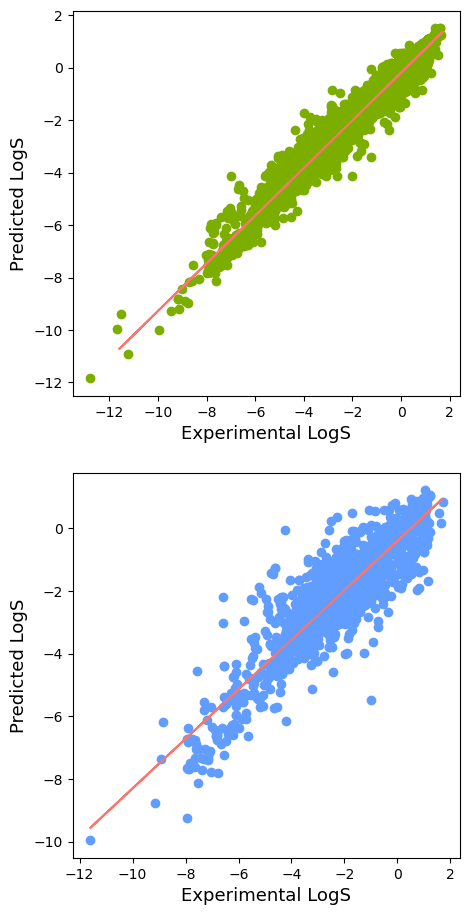

In [29]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)

# 出力
#plt.savefig('output/plot_vertical_logS_ECFP_RFR.png')
#plt.savefig('output/paper logS descriptor_ECFP_RFR.pdf',dpi=300)

plt.show()

## Case2: 2048ビット
ここでは枝狩りをしていない2048ビットを特徴量としたときの精度も比較考証をしています。

### データセットの分割（Data set splitting）

In [30]:
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=991
                                                   )

### 2-3.線形重回帰 (MLR) 

In [31]:
linearmodel=LinearRegression()
linearmodel.fit(X_train, Y_train)

LinearRegression()

### R2スコア

In [32]:
#predicts the X_train
Y_pred_train = linearmodel.predict(X_train)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))

Mean squared error (MSE): 0.74
Coefficient of determination (R^2): 0.84


In [33]:
#predicts the X_test
Y_pred_test = reg.predict(X_test)

print('Mean squared error (MSE): %.3f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))

print('Coefficient of determination (R^2): %.3f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.935
Coefficient of determination (R^2): 0.753


### MAE

In [34]:
mae = mean_absolute_error(Y_train, Y_pred_train)
print('Training MAE : {:.3f}'.format(mae))

Training MAE : 0.550


In [35]:
mae = mean_absolute_error(Y_test, Y_pred_test)
print('Test MAE : {:.3f}'.format(mae))

Test MAE : 0.706


### RMSE

In [36]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.3f}'.format(rmse))

Training RMSE : 0.736


In [37]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.3f}'.format(rmse))

Test RMSE : 0.935


### Exp-Predict Plot

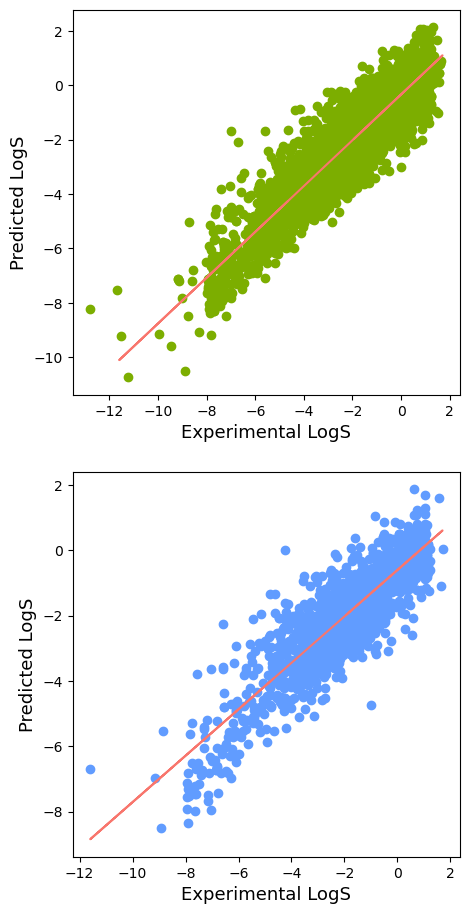

In [38]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.xlabel('Experimental LogS', fontsize=13)
plt.ylabel('Predicted LogS', fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS', fontsize=13)
plt.xlabel('Experimental LogS', fontsize=13)

# 出力
#plt.savefig('output/plot_vertical_logS_ECFP__MLR_2048.png')
#plt.savefig('output/paper logS ECFP__MLR_2048.pdf',dpi=300)

plt.show()

### 係数の出力

In [39]:
# Print out the coefficients for each fingerprint
for i in range(len(X[0])):
    print("Bit", i, ":", reg.coef_[i])

Bit 0 : 0.15992486260998626
Bit 1 : -0.314310741986557
Bit 2 : -0.47280287374293856
Bit 3 : -0.0
Bit 4 : -0.0
Bit 5 : -0.0
Bit 6 : -0.0
Bit 7 : 0.0
Bit 8 : -0.0
Bit 9 : -0.3470528778216867
Bit 10 : -0.0
Bit 11 : 0.0
Bit 12 : -0.0
Bit 13 : 0.027709619200126927
Bit 14 : 0.0
Bit 15 : 0.0
Bit 16 : -0.3010756541847232
Bit 17 : -0.0
Bit 18 : 0.0
Bit 19 : -0.0
Bit 20 : -0.0
Bit 21 : 0.0
Bit 22 : -0.0
Bit 23 : -0.0
Bit 24 : 0.0
Bit 25 : -0.04018562205882949
Bit 26 : 0.0
Bit 27 : 0.0
Bit 28 : -0.0970214909725354
Bit 29 : -0.0
Bit 30 : -0.0
Bit 31 : -0.33521220002929825
Bit 32 : -0.0
Bit 33 : -0.0
Bit 34 : 0.03380562901904102
Bit 35 : -0.0
Bit 36 : 0.0
Bit 37 : -0.0
Bit 38 : -0.0
Bit 39 : -0.21536888667525103
Bit 40 : 0.0
Bit 41 : 0.31535895618497073
Bit 42 : 0.0
Bit 43 : -0.0
Bit 44 : -0.5337646822379348
Bit 45 : -0.0
Bit 46 : -0.0
Bit 47 : -0.0
Bit 48 : 0.0
Bit 49 : -0.0
Bit 50 : 0.0
Bit 51 : -0.0
Bit 52 : -0.0
Bit 53 : 0.0
Bit 54 : -0.0
Bit 55 : 0.0
Bit 56 : 0.1876388588317961
Bit 57 : 0.0
Bi

In [40]:
import csv
with open('output/coefficients.csv', mode='w') as file:
    writer = csv.writer(file)
    for i in range(len(X[0])):
        writer.writerow(['Bit ' + str(i), reg.coef_[i]])

### 2-4.ランダムフォレスト回帰（RFR）

In [41]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

RandomForestRegressor(random_state=42)

### R2スコア

In [42]:
#predicts the X_train
Y_pred_train = model.predict(X_train)

print('Mean squared error (RMSE): %.2f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_train, Y_pred_train))


Mean squared error (RMSE): 0.35
Coefficient of determination (R^2): 0.96


In [43]:
Y_pred_test = model.predict(X_test)

print('Mean squared error (MSE): %.2f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))

print('Coefficient of determination (R^2): %.2f'
      % r2_score(Y_test, Y_pred_test))

Mean squared error (MSE): 0.81
Coefficient of determination (R^2): 0.81


### MAE

In [44]:
mae = mean_absolute_error(Y_train, Y_pred_train)
mae

0.23154590595706465

In [45]:
mae = mean_absolute_error(Y_test, Y_pred_test)
mae

0.5555834548223916

### RMSE

In [46]:
rmse = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
print('Training RMSE : {:.3f}'.format(rmse))

Training RMSE : 0.352


In [47]:
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print('Test RMSE : {:.3f}'.format(rmse))

Test RMSE : 0.810


### Exp-Predict Plot

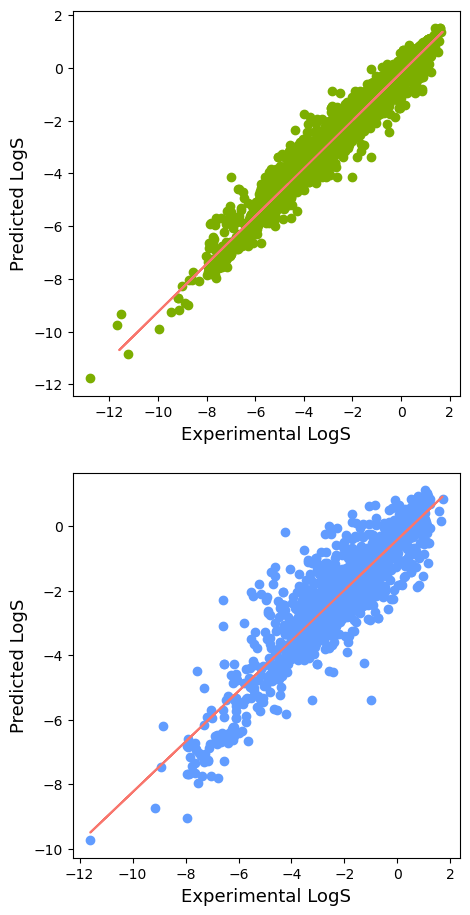

In [48]:
#Vertical plot
plt.figure(figsize=(5,11))

# 2 row, 1 column, plot 1
plt.subplot(2, 1, 1)
plt.scatter(x=Y_train, y=Y_pred_train, c="#7CAE00", alpha=1)

# Add trendline
# https://stackoverflow.com/questions/26447191/how-to-add-trendline-in-python-matplotlib-dot-scatter-graphs
z = np.polyfit(Y_train, Y_pred_train, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")


plt.xlabel('Experimental LogS',fontsize=13)
plt.ylabel('Predicted LogS',fontsize=13)


# 2 row, 1 column, plot 2
plt.subplot(2, 1, 2)
plt.scatter(x=Y_test, y=Y_pred_test, c="#619CFF", alpha=1)

z = np.polyfit(Y_test, Y_pred_test, 1)
p = np.poly1d(z)
plt.plot(Y_test,p(Y_test),"#F8766D")

plt.ylabel('Predicted LogS',fontsize=13)
plt.xlabel('Experimental LogS',fontsize=13)

# 出力
#plt.savefig('plot_vertical_logS.png')
#plt.savefig('output/paper logS morgan_ECFP_2048_RF.pdf',dpi=300)

plt.show()

### 3. SHAP計算

In [49]:
import shap
from sklearn.preprocessing import StandardScaler

In [50]:
%%time

X = X_test
Xscaler = StandardScaler()
X2= Xscaler.fit_transform(X)

explainer = shap.TreeExplainer(model,data=X2,
                               feature_perturbation='interventional'
                              )

shap_values = explainer.shap_values(X2)

100%|===================| 1684/1688 [02:56<00:00]        

CPU times: total: 2min 29s
Wall time: 2min 57s


### beeswarm plot

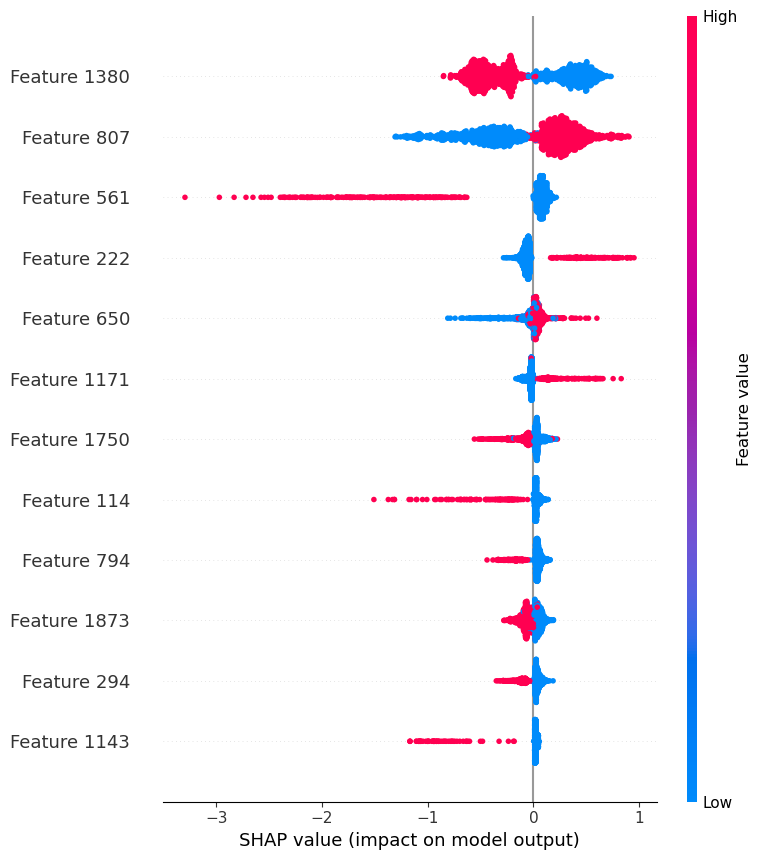

In [51]:
shap.summary_plot(shap_values, 
                  X2, 
                  plot_type="dot", 
                  plot_size=0.6, 
                  show=False,
                  max_display=12
                 )

### Global bar plot

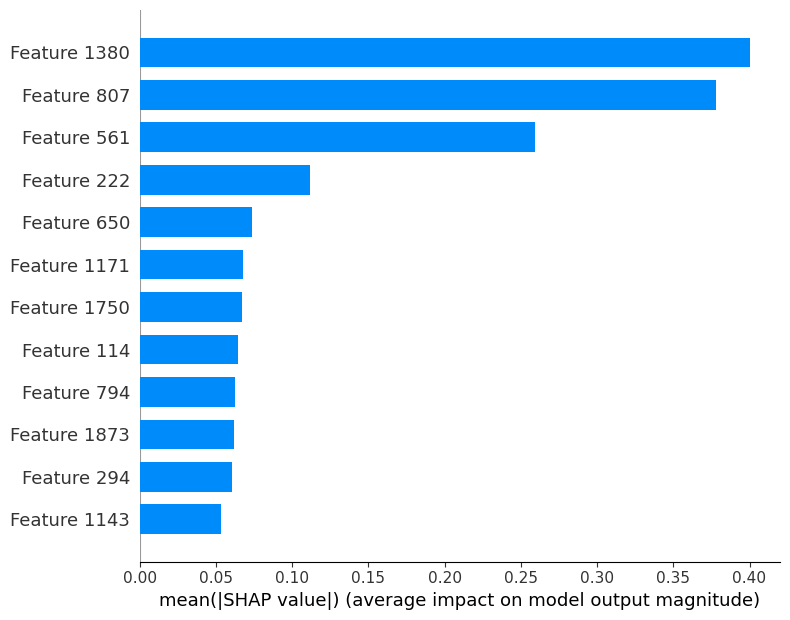

In [52]:
shap.summary_plot(shap_values, 
                  max_display=12, 
                  plot_type="bar",
                  show=False
                 )

### 係数の出力

In [53]:
vals= np.abs(shap_values).mean(0)

i=12

feature_importance = pd.DataFrame(list(zip(X2[i], vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance[:12]

,col_name,feature_importance_vals
1380,0.798277,0.399984
807,-1.160907,0.377838
561,-0.383065,0.259487
222,-0.322474,0.112054
650,0.836600,0.073622
1171,-0.471490,0.067750
1750,1.263694,0.067339
114,-0.292456,0.064362
794,-0.356140,0.062827
1873,0.945780,0.061868


In [54]:
feature_importance.to_excel(r'output/File Name44.xlsx', index = False)

### 4.ブラインドテスト
Additional Fileとして提供されているtestexperiment2upload3raw.csvでの事例です。

### ブラインドテスト 1

In [55]:
#Blind test
sol2 = pd.read_csv('data/testexperiment2upload3raw.csv')
print(sol2.head)
XY2 = sol2.set_index('SMILES').T.to_dict('list')

<bound method NDFrame.head of                              Substance  \
0                         hexobarbital   
1                       nalidixic_acid   
2                        phenantroline   
3                        phenobarbital   
4                       sulfamethazine   
5                         bromogramine   
6                      phenazopyridine   
7                           amantadine   
8                      benzylimidazole   
9                       chlorpropamide   
10                          cimetidine   
11                              thymol   
12                          tryptamine   
13                        azathioprine   
14                       sulfathiazole   
15                       acetaminophen   
16                           diazoxide   
17                          famotidine   
18                  hydroflumethiazide   
19                      nitrofurantoin   
20                phthalic_acid_form_I   
21                       sulfacetamide   
22  

In [56]:
X3 = []

for smile, Hlist in XY2.items():
    try:
        X3.append(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2,nBits = 2048))

    except:
        pass
    
X3 = [list(c) for c in X3]
print(len(X3))

32


In [57]:
Xnew=X3
ynew = model.predict(Xnew)
ynew

array([-2.34042833, -3.41649787, -1.820265  , -2.33071771, -2.36339588,
       -3.86828911, -4.02626667, -2.14655   , -1.60452667, -2.8991032 ,
       -1.49360145, -2.262565  , -2.90225   , -2.88325   , -2.5433351 ,
       -1.18765162, -3.33694308, -2.58238314, -2.34857   , -3.41979427,
       -0.9446275 , -1.41829808, -2.77631587, -2.79165   , -2.18803067,
       -2.85966907, -1.7005101 , -2.0005    , -1.35115913, -4.13441   ,
       -2.34481357, -2.26048   ])

### ブラインドテスト 2

In [58]:
#Solubility Challenge
sol3 = pd.read_csv('data/testexperiment2upload2raw.csv')
print(sol3.head)
XY3 = sol3.set_index('SMILES').T.to_dict('list')

<bound method NDFrame.head of                      name                                             SMILES
0              Acebutolol        CC(C)NCC(O)COC1=C(C(C)=O)C=C(NC(CCC)=O)C=C1
1             Amoxicillin  O=C(O)[C@H]1C(C)(C)S[C@@H](N21)[C@H](NC([C@@H]...
2     Bendroflumethiazide  O=S1(C2=CC(S(N)(=O)=O)=C(C(F)(F)F)C=C2NC(CC3=C...
3              Benzocaine                             NC1=CC=C(C(OCC)=O)C=C1
4            Benzthiazide  O=S1(C2=CC(S(N)(=O)=O)=C(Cl)C=C2N=C(CSCC3=CC=C...
5   2-chloromandelic_acid                            OC(C(O)C1=CC=CC=C1Cl)=O
6               Clozapine    ClC(C=C1)=CC2=C1NC(C=CC=C3)=C3C(N4CCN(C)CC4)=N2
7               Dibucaine        CCN(CC)CCNC(C1=C(C=CC=C2)C2=NC(OCCCC)=C1)=O
8      Diethylstilbestrol          CC/C(C1=CC=C(O)C=C1)=C(C2=CC=C(O)C=C2)/CC
9              Diflunisal              FC(C=C1F)=CC=C1C2=CC=C(O)C(C(O)=O)=C2
10           Dipyridamole  OCCN(CCO)C1=NC2=C(N3CCCCC3)N=C(N(CCO)CCO)N=C2C...
11              Ephedrine                     

In [59]:
X4 = []

for smile, Hlist in XY3.items():
    try:
        X4.append(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smile), radius=2,nBits = 2048))

    except:
        pass
X4 = [list(c) for c in X4]
print(len(X4))

32


In [60]:
X2new=X4
y2new = model.predict(X2new)
y2new

array([-2.5055    , -1.8475626 , -2.53903117, -2.4453825 , -2.876951  ,
       -1.1277    , -3.02360071, -2.49747109, -2.09193   , -2.16782684,
       -0.43596838, -0.98484333, -2.03495333, -3.70215845, -2.72960217,
       -2.07225917, -2.8733125 , -2.90893333, -1.821875  , -2.0456418 ,
       -1.76582838, -3.38088   , -0.98484333, -2.45915083, -3.892605  ,
       -1.44041   , -2.886162  , -2.92048395, -1.69115533, -2.90018408,
       -3.18540333, -2.49854983])

### 予測値の出力保存

In [ ]:
# define data
data = np.asarray(ynew)

# save to csv file
np.savetxt('output/data_ECFP.csv', data, delimiter=',')

### 可視化

In [5]:
from rdkit.Chem import rdMolDescriptors

In [6]:
z = sol.iloc[:,0]
z

0                 OCC1OC(CO)(OC2OC(CO)C(O)C(O)C2O)C(O)C1O
1       O[C@H]1[C@H](O[C@H](CO)[C@@H](O)[C@@H]1O)O[C@]...
2       OC[C@@H]1O[C@](CO)(O[C@@H]2O[C@@H](CO)[C@H](O)...
3                  CN1C[C@@H]2C[C@@H](C1)C3=CC=CC(=O)N3C2
4                            CN1CC2CC(C1)C1=CC=CC(=O)N1C2
                              ...                        
8433                                        O=[N+]([O-])C
8434                                                   OC
8435                                              S=C(N)N
8436                                             O=C(NO)N
8437                                              O=C(N)N
Name: SMILES, Length: 8438, dtype: object

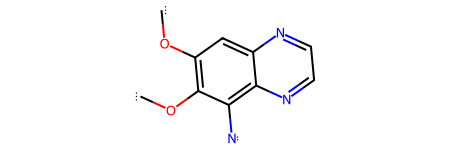

In [15]:
w = Chem.MolFromSmiles(z[1814])
w

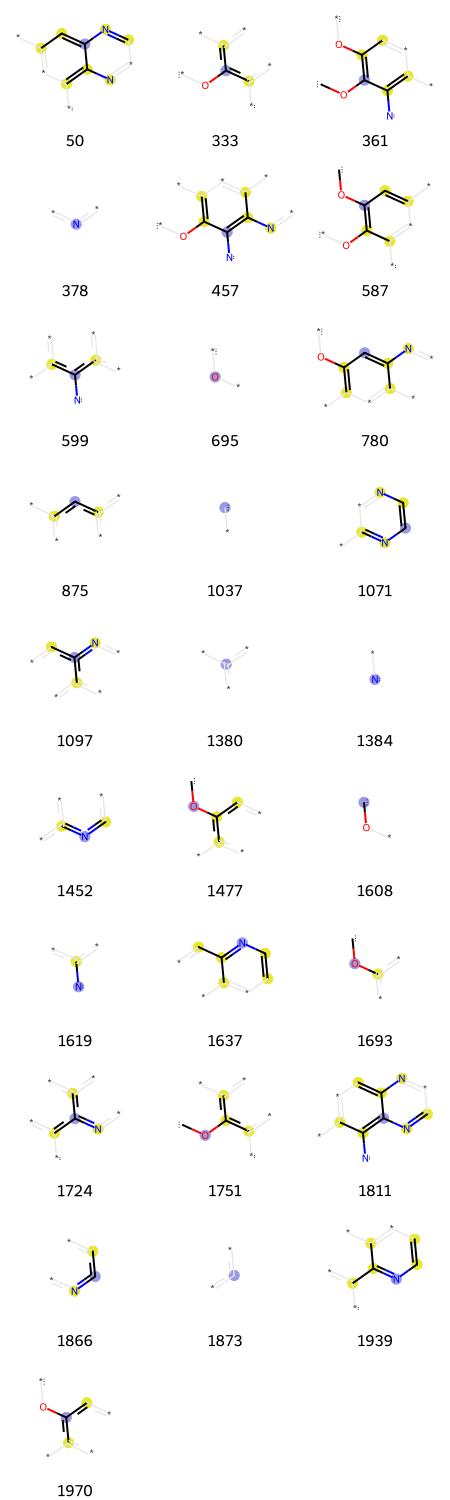

In [16]:
bi = {}

fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(w, 
                                                    radius=2, 
                                                    bitInfo=bi, 
                                                    nBits = 2048
                                                   )

tpls = [(w,x,bi) for x in fp.GetOnBits()]

p = Draw.DrawMorganBits(tpls[:],
                        molsPerRow=3,
                        legends=[str(x) for x in fp.GetOnBits()][:]
                       )
p

### 【参考】 Figure2の作成

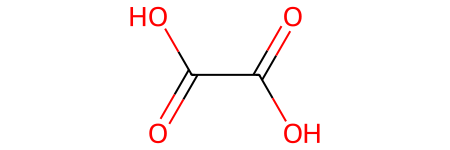

In [19]:
w = Chem.MolFromSmiles(z[8402])
w

In [23]:
bi_bz = {}
fp_bz = AllChem.GetMorganFingerprintAsBitVect(w,
                                              radius=2,
                                              nBits=2048,
                                              bitInfo=bi_bz)

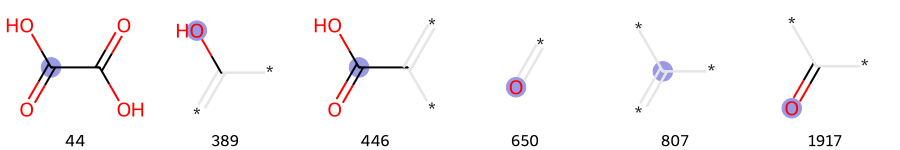

In [25]:
tpls = [(w,x,bi_bz) for x in fp_bz.GetOnBits()]

p = Draw.DrawMorganBits(tpls[:],
                        molsPerRow=6,
                        legends=[str(x) for x in fp_bz.GetOnBits()][:]
                       )
p